# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [138]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [139]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [140]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [141]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [142]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [143]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [144]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [145]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [146]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [147]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [148]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [149]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [150]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [151]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [152]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [153]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [154]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [155]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [156]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [157]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [158]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [159]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())


100%|██████████| 4986/4986 [00:02<00:00, 2086.19it/s]


In [160]:
final['CleanedText'] = preprocessed_reviews
y = final['Score']

In [161]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

In [162]:
## Similartly you can do preprocessing for review summary also.

# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

In [163]:
#Splitting data into train and test:

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection

X_train, X_test, y_train, y_test = train_test_split(final, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#Splitting train data into train and cv(60:20)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_train, y_train, test_size=0.2)
print(X_tr.shape, y_tr.shape)
print(X_cv.shape, y_cv.shape)



(3988, 11) (3988,)
(998, 11) (998,)
(3190, 11) (3190,)
(798, 11) (798,)


In [164]:
#Applying BoW
model = CountVectorizer()
model.fit(X_tr['CleanedText'])
train_bow = model.transform(X_tr['CleanedText'])
cv_bow = model.transform(X_cv['CleanedText'])
test_bow = model.transform(X_test['CleanedText'])
print(test_bow.shape)
print(cv_bow.shape)
print(train_bow.shape)

(998, 10526)
(798, 10526)
(3190, 10526)


In [165]:
#Applying tf_idf vectorization
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df = 10, max_features = 500)
tf_idf_vect.fit(X_tr['Text'])
train_tf_idf = tf_idf_vect.transform(X_tr['Text'])
test_tf_idf = tf_idf_vect.transform(X_test['Text'])
cv_tf_idf = tf_idf_vect.transform(X_cv['Text'])

print(test_tf_idf.shape)
print(train_tf_idf.shape)
print(cv_tf_idf.shape)

(998, 500)
(3190, 500)
(798, 500)


In [166]:
# Word2Vec model for train
i=0
list_of_sent=[]
for sent in X_tr['CleanedText'].values:
    list_of_sent.append(sent.split())
    
print(X_tr['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])


# Word2Vec model for test and CV
i=0
list_of_sent_cv=[]
for sent in X_cv['CleanedText'].values:
    list_of_sent_cv.append(sent.split())
    
print(X_cv['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent_cv[0])


i=0
list_of_sent_test=[]
for sent in X_test['CleanedText'].values:
    list_of_sent_test.append(sent.split())
    
print(X_test['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent_test[0])


w2v_model_train=Word2Vec(list_of_sent,min_count=5,size=50, workers=5)
w2v_model_test=Word2Vec(list_of_sent_test,min_count=5,size=50, workers=5)
w2v_model_cv=Word2Vec(list_of_sent_cv,min_count=5,size=50, workers=5)


w2v_words = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence
    sent_vec_test = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))


# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_cv): # for each review/sentence
    sent_vec_cv = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

option star rating would rate item first sampling include varieties included appears two flavors stock not substituted two flavors instead remaining flavors tossed box expected limited edition coffee flavor island coconut stock would replaced different limited edition coffee flavor thing half half lemonade second order not balanced flavors receive coffees remaining teas concept summer sampler set good one execution epic fail order returned today
*****************************************************************
['option', 'star', 'rating', 'would', 'rate', 'item', 'first', 'sampling', 'include', 'varieties', 'included', 'appears', 'two', 'flavors', 'stock', 'not', 'substituted', 'two', 'flavors', 'instead', 'remaining', 'flavors', 'tossed', 'box', 'expected', 'limited', 'edition', 'coffee', 'flavor', 'island', 'coconut', 'stock', 'would', 'replaced', 'different', 'limited', 'edition', 'coffee', 'flavor', 'thing', 'half', 'half', 'lemonade', 'second', 'order', 'not', 'balanced', 'flavors

100%|██████████| 3190/3190 [00:03<00:00, 975.53it/s] 


3190
50


100%|██████████| 998/998 [00:01<00:00, 998.00it/s] 


998
50


100%|██████████| 798/798 [00:00<00:00, 950.00it/s]


798
50


In [167]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_tr['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [168]:

w2v_model_train=Word2Vec(list_of_sent,min_count=5,size=50, workers=5)
w2v_model_test=Word2Vec(list_of_sent_test,min_count=5,size=50, workers=5)
w2v_model_cv=Word2Vec(list_of_sent_cv,min_count=5,size=50, workers=5)


w2v_words = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
    
    
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1


number of words that occured minimum 5 times  2978
sample words  ['option', 'star', 'rating', 'would', 'rate', 'item', 'first', 'include', 'varieties', 'included', 'appears', 'two', 'flavors', 'stock', 'not', 'instead', 'remaining', 'tossed', 'box', 'expected', 'limited', 'coffee', 'flavor', 'coconut', 'replaced', 'different', 'thing', 'half', 'lemonade', 'second', 'order', 'balanced', 'receive', 'coffees', 'teas', 'summer', 'sampler', 'set', 'good', 'one', 'fail', 'returned', 'today', 'iced', 'tea', 'terrible', 'stash', 'product', 'enjoy', 'tastes']


100%|██████████| 798/798 [00:04<00:00, 165.22it/s]


# Applying SVM

## [5.1] RBF SVM

### [5.1.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [170]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
C_range = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]
gamma_range = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]
param_grid = {'C':C_range,'gamma':gamma_range}
#base_estimator = linear_model.SGDClassifier(loss='hinge',penalty='l2', random_state=0)
scoring = {'AUC': 'roc_auc'}
clf=svm.SVC(kernel='rbf',class_weight = 'balanced')
grid = GridSearchCV(clf,param_grid=param_grid,scoring = scoring, refit = 'AUC')
grid.fit(train_bow, y_tr) 
print(grid)
# summarize the results of the grid search
(grid.best_score_)
print(grid.best_estimator_.C)
print(grid.best_estimator_.gamma)
results_tr = grid.cv_results_ 
#print(results)
 

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 1, 10, 100, 1000], 'gamma': [1e-05, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring={'AUC': 'roc_auc'}, verbose=0)
10
0.001


In [171]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
C_range = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]
gamma_range = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]
param_grid = {'C':C_range,'gamma':gamma_range}
#base_estimator = linear_model.SGDClassifier(loss='hinge',penalty='l2', random_state=0)
scoring = {'AUC': 'roc_auc'}
clf=svm.SVC(kernel='rbf',class_weight = 'balanced')
grid = GridSearchCV(clf,param_grid=param_grid,scoring = scoring, refit = 'AUC')
grid.fit(cv_bow, y_cv) 
print(grid)
# summarize the results of the grid search
(grid.best_score_)
print(grid.best_estimator_.C)
print(grid.best_estimator_.gamma)
results_cv = grid.cv_results_ 
#print(results)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 1, 10, 100, 1000], 'gamma': [1e-05, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring={'AUC': 'roc_auc'}, verbose=0)
100
0.0001


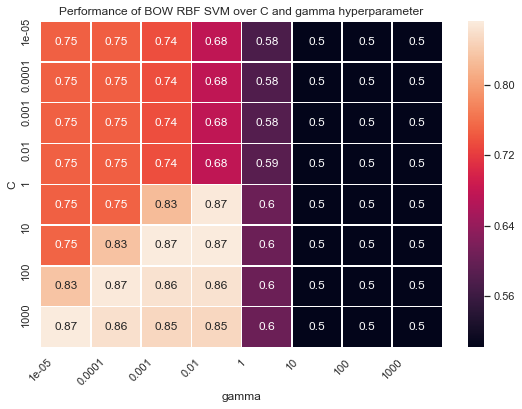

In [172]:
import seaborn as sns
#plt.figure(figsize=(13, 13))
#plt.title("Performance of BOW RBF SVM over C hyperparameter",
          #fontsize=16)
#ax = plt.gca()
scores = results_tr['mean_test_AUC'].reshape(len(C_range),len(gamma_range))
## Plotting Function
#plt.figure(figsize=(8, 6))
sns.set()
#plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(scores, annot=True, linewidths=.5, ax=ax)
#plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
#plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Performance of BOW RBF SVM over C and gamma hyperparameter')
plt.show()

Area under the ROC curve : %f 0.907112150415722
[[ 90  36]
 [ 73 599]]


Text(0.5, 12.5, 'Predicted label')

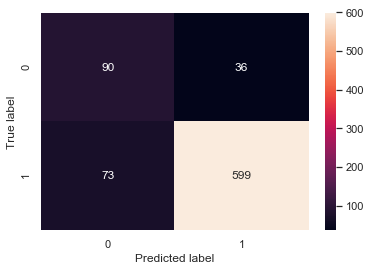

In [173]:
# After finding the best hyperparameter value for BOW which is 0.001, applying RBF SVM on train dataset and predicting
# accuracy/AUC score for cv dataset
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
clf = svm.SVC(kernel='rbf',gamma=0.001,C=10)
scoring = {'AUC': 'roc_auc'}
clf.fit(train_bow,y_tr)
#cf = clf.predict(cv_bow)
#Caliberate the classifier.
clf_calibrated=CalibratedClassifierCV(clf, cv='prefit', method='isotonic')
cclf = clf_calibrated.fit(train_bow, y_tr).predict(cv_bow)
pred_cv = clf_calibrated.predict_proba(cv_bow)[:,1];
#F1 Score
#print("F1 score:\n",metrics.roc_curve(y_cv,pred_cv, pos_label=1, sample_weight=None))
#AUC score
fpr, tpr, thresholds = roc_curve(y_cv,pred_cv)
roc_auc_cv = auc(fpr, tpr)
print('Area under the ROC curve : %f', + roc_auc_cv)

#Plotting confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(y_cv, cclf)
print(conf_mat)
#conf_normalized = conf_mat.astype('int') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat, annot=True, fmt ='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')


Area under the ROC curve : 0.9078438118173218
[[118  33]
 [ 85 762]]


Text(0.5, 12.5, 'Predicted label')

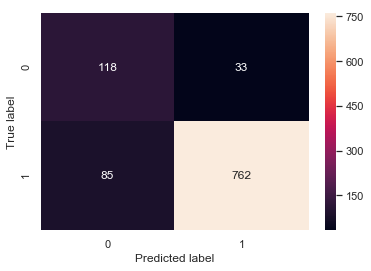

In [174]:
# After finding the best hyperparameter value for BOW which is 0.001, applying RBF SVM on train dataset and predicting
# accuracy/AUC score for cv dataset
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
clf = svm.SVC(kernel='rbf',gamma=0.001,C=10)
scoring = {'AUC': 'roc_auc'}
clf.fit(train_bow,y_tr)
#cf = clf.predict(test_bow)
#Caliberate the classifier.
clf_calibrated=CalibratedClassifierCV(clf, cv='prefit', method='isotonic')
cclf = clf_calibrated.fit(train_bow, y_tr).predict(test_bow) 
pred_test = clf_calibrated.predict_proba(test_bow)[:,1];
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc_test = auc(fpr, tpr)
print('Area under the ROC curve :', + roc_auc_test)
#Plotting confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(y_test, cclf)
print(conf_mat)
#conf_normalized = conf_mat.astype('int') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat, annot=True, fmt ='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')


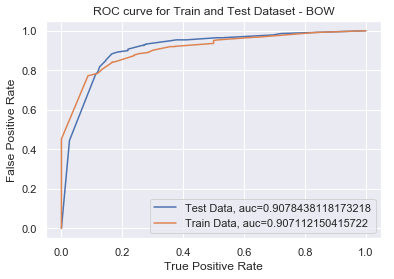

In [175]:
plt.figure(0).clf()
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc_test = auc(fpr, tpr)
plt.plot(fpr,tpr,label="Test Data, auc="+str(roc_auc_test))

fpr, tpr, thresh = roc_curve(y_cv, pred_cv)
roc_auc_cv = auc(fpr, tpr)
plt.plot(fpr,tpr,label="Train Data, auc="+str(roc_auc_cv))
plt.title('ROC curve for Train and Test Dataset - BOW')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.legend(loc=0)

### [5.1.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [176]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
C_range = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]
gamma_range = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]
param_grid = {'C':C_range,'gamma':gamma_range}
#base_estimator = linear_model.SGDClassifier(loss='hinge',penalty='l2', random_state=0)
scoring = {'AUC': 'roc_auc'}
clf=svm.SVC(kernel='rbf')
grid = GridSearchCV(clf,param_grid=param_grid,scoring = scoring, refit = 'AUC')
grid.fit(train_tf_idf, y_tr) 
print(grid)
# summarize the results of the grid search
(grid.best_score_)
print(grid.best_estimator_.C)
print(grid.best_estimator_.gamma)
results_tr_tf = grid.cv_results_ 
#print(results)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 1, 10, 100, 1000], 'gamma': [1e-05, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring={'AUC': 'roc_auc'}, verbose=0)
10
1


In [177]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
C_range = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]
gamma_range = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]
param_grid = {'C':C_range,'gamma':gamma_range}
#base_estimator = linear_model.SGDClassifier(loss='hinge',penalty='l2', random_state=0)
scoring = {'AUC': 'roc_auc'}
clf=svm.SVC(kernel='rbf')
grid = GridSearchCV(clf,param_grid=param_grid,scoring = scoring, refit = 'AUC')
grid.fit(cv_tf_idf, y_cv) 
print(grid)
# summarize the results of the grid search
(grid.best_score_)
print(grid.best_estimator_.C)
print(grid.best_estimator_.gamma)
results_cv_tf = grid.cv_results_ 
#print(results)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 1, 10, 100, 1000], 'gamma': [1e-05, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring={'AUC': 'roc_auc'}, verbose=0)
10
1


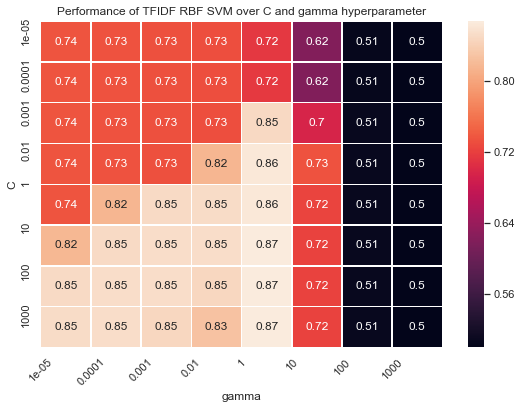

In [178]:
import seaborn as sns
scores = results_tr_tf['mean_test_AUC'].reshape(len(C_range),len(gamma_range))
sns.set()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(scores, annot=True, linewidths=.5, ax=ax)
plt.xlabel('gamma')
plt.ylabel('C')
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Performance of TFIDF RBF SVM over C and gamma hyperparameter')
plt.show()




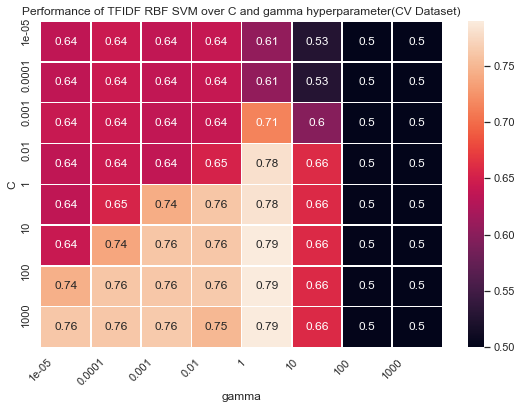

In [179]:
scores_cv = results_cv_tf['mean_test_AUC'].reshape(len(C_range),len(gamma_range))
sns.set()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(scores_cv, annot=True, linewidths=.5, ax=ax)
plt.xlabel('gamma')
plt.ylabel('C')
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Performance of TFIDF RBF SVM over C and gamma hyperparameter(CV Dataset)')
plt.show()

Area under the ROC curve : %f 0.8429114701436131
[[ 35  91]
 [ 26 646]]


Text(0.5, 12.5, 'Predicted label')

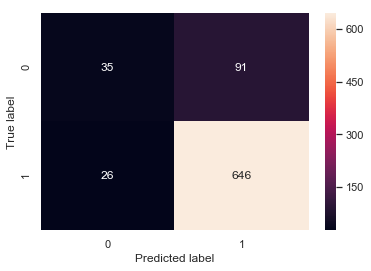

In [181]:
# After finding the best hyperparameter value for BOW which is 0.001, applying RBF SVM on train dataset and predicting
# accuracy/AUC score for cv dataset
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
clf = svm.SVC(kernel='rbf',gamma=1,C=10)
scoring = {'AUC': 'roc_auc'}
clf.fit(train_tf_idf,y_tr)
#cf = clf.predict(cv_tf_idf)
#Caliberate the classifier.
clf_calibrated=CalibratedClassifierCV(clf, cv='prefit', method='isotonic')
cclf = clf_calibrated.fit(train_tf_idf, y_tr).predict(cv_tf_idf) 
pred_cv = clf_calibrated.predict_proba(cv_tf_idf)[:,1];
fpr, tpr, thresholds = roc_curve(y_cv,pred_cv)
roc_auc_cv_tfidf = auc(fpr, tpr)
print('Area under the ROC curve : %f', + roc_auc_cv_tfidf)

#Plotting confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(y_cv, cclf)
print(conf_mat)
#conf_normalized = conf_mat.astype('int') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat, annot=True, fmt ='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')


Area under the ROC curve : %f 0.8873546682095748
[[ 64  87]
 [ 22 825]]


Text(0.5, 12.5, 'Predicted label')

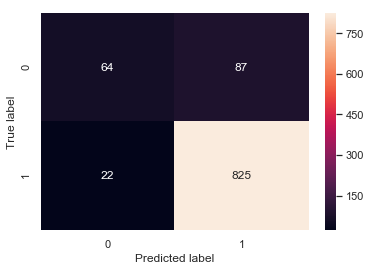

In [182]:
# After finding the best hyperparameter value for BOW which is 0.001, applying RBF SVM on train dataset and predicting
# accuracy/AUC score for cv dataset
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
clf = svm.SVC(kernel='rbf',gamma=1,C=10)
scoring = {'AUC': 'roc_auc'}
clf.fit(train_tf_idf,y_tr)
#cf = clf.predict(test_tf_idf)
#Caliberate the classifier.
clf_calibrated=CalibratedClassifierCV(clf, cv='prefit', method='isotonic')
y_pred = clf_calibrated.fit(train_tf_idf, y_tr).predict(test_tf_idf)
pred_test = clf_calibrated.predict_proba(test_tf_idf)[:,1];
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc_test_tfidf = auc(fpr, tpr)
print('Area under the ROC curve : %f', + roc_auc_test_tfidf)

#Plotting confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
#conf_normalized = conf_mat.astype('int') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat, annot=True, fmt ='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')


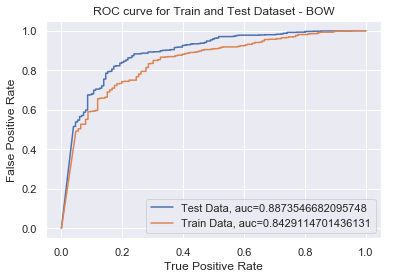

In [183]:
plt.figure(0).clf()
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc_test_tfidf = auc(fpr, tpr)
plt.plot(fpr,tpr,label="Test Data, auc="+str(roc_auc_test_tfidf))

fpr, tpr, thresh = roc_curve(y_cv, pred_cv)
roc_auc_cv_tfidf = auc(fpr, tpr)
plt.plot(fpr,tpr,label="Train Data, auc="+str(roc_auc_cv_tfidf))
plt.title('ROC curve for Train and Test Dataset - BOW')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.legend(loc=0)

### [5.1.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [184]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
C_range = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]
gamma_range = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]
param_grid = {'C':C_range,'gamma':gamma_range}
#base_estimator = linear_model.SGDClassifier(loss='hinge',penalty='l2', random_state=0)
scoring = {'AUC': 'roc_auc'}
clf=svm.SVC(kernel='rbf')
grid = GridSearchCV(clf,param_grid=param_grid,scoring = scoring, refit = 'AUC')
grid.fit(sent_vectors, y_tr) 
print(grid)
# summarize the results of the grid search
(grid.best_score_)
print(grid.best_estimator_.C)
print(grid.best_estimator_.gamma)
results_tr_avg = grid.cv_results_ 
#print(results)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 1, 10, 100, 1000], 'gamma': [1e-05, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring={'AUC': 'roc_auc'}, verbose=0)
1000
0.01


In [120]:
grid = GridSearchCV(clf,param_grid=param_grid,scoring = scoring, refit = 'AUC')
grid.fit(sent_vectors_cv, y_cv) 
print(grid)
# summarize the results of the grid search
(grid.best_score_)
print(grid.best_estimator_.C)
print(grid.best_estimator_.gamma)
results_cv_avg = grid.cv_results_ 
#print(results)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 1, 10, 100, 1000], 'gamma': [1e-05, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring={'AUC': 'roc_auc'}, verbose=0)
1e-05
1e-05


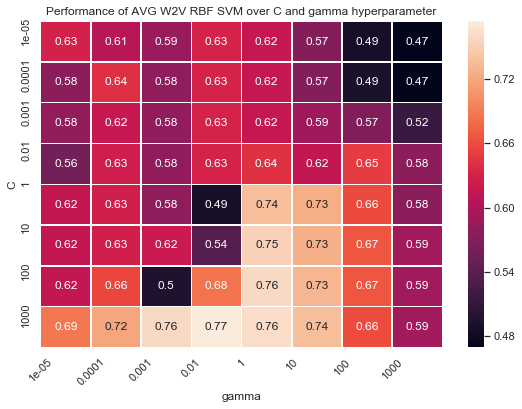

In [185]:
import seaborn as sns
scores = results_tr_avg['mean_test_AUC'].reshape(len(C_range),len(gamma_range))
sns.set()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(scores, annot=True, linewidths=.5, ax=ax)
plt.xlabel('gamma')
plt.ylabel('C')
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Performance of AVG W2V RBF SVM over C and gamma hyperparameter')
plt.show()


Area under the ROC curve : %f 0.805165486366524
[[ 141  390]
 [  71 2588]]


Text(0.5, 12.5, 'Predicted label')

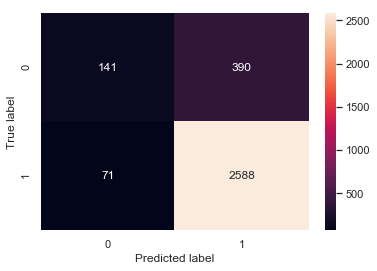

In [186]:
# After finding the best hyperparameter value for AVG W2V which is 0.001, applying RBF SVM on train dataset and predicting
# accuracy/AUC score for cv dataset
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
clf = svm.SVC(kernel='rbf',gamma=0.01,C=1000)
scoring = {'AUC': 'roc_auc'}
clf.fit(sent_vectors,y_tr)
#cf = clf.predict(sent_vectors)
#Caliberate the classifier.
clf_calibrated=CalibratedClassifierCV(clf, cv='prefit', method='isotonic')
y_pred = clf_calibrated.fit(sent_vectors, y_tr).predict(sent_vectors) 
pred_cv = clf_calibrated.predict_proba(sent_vectors)[:,1]
fpr, tpr, thresholds = roc_curve(y_tr,pred_cv)
roc_auc_cv_tfidf = auc(fpr, tpr)
print('Area under the ROC curve : %f', + roc_auc_cv_tfidf)

#Plotting confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(y_tr, y_pred)
print(conf_mat)
#conf_normalized = conf_mat.astype('int') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat, annot=True, fmt ='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')



Area under the ROC curve : %f 0.5
[[  0 151]
 [  0 847]]


Text(0.5, 12.5, 'Predicted label')

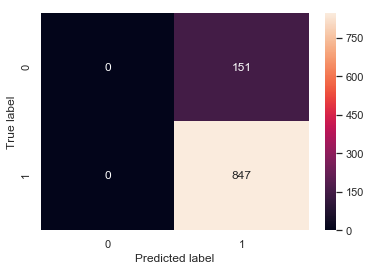

In [187]:
clf = svm.SVC(kernel='rbf',gamma=0.01,C=1000)
scoring = {'AUC': 'roc_auc'}
clf.fit(sent_vectors,y_tr)
#cf = clf.predict(sent_vectors_test)
#Caliberate the classifier.
clf_calibrated=CalibratedClassifierCV(clf, cv='prefit', method='isotonic')
y_pred = clf_calibrated.fit(sent_vectors, y_tr).predict(sent_vectors_test)
#y_pred = clf_calibrated.fit(tfidf_sent_vectors, y_tr).predict(tfidf_sent_vectors_test) 
pred_test = (clf_calibrated.predict_proba(sent_vectors_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc_test_tfidf = auc(fpr, tpr)
print('Area under the ROC curve : %f', + roc_auc_test_tfidf)

#Plotting confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
#conf_normalized = conf_mat.astype('int') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat, annot=True, fmt ='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')



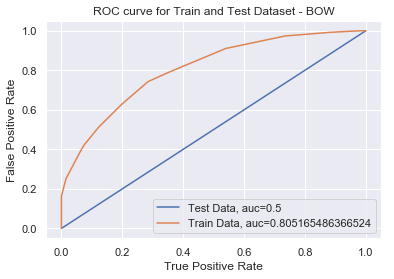

In [188]:
plt.figure(0).clf()
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc_test_tfidf = auc(fpr, tpr)
plt.plot(fpr,tpr,label="Test Data, auc="+str(roc_auc_test_tfidf))

fpr, tpr, thresh = roc_curve(y_tr, pred_cv)
roc_auc_cv_tfidf = auc(fpr, tpr)
plt.plot(fpr,tpr,label="Train Data, auc="+str(roc_auc_cv_tfidf))
plt.title('ROC curve for Train and Test Dataset - BOW')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.legend(loc=0)

### [5.1.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [189]:
# Please write all the code with proper documentation

from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
C_range = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]
gamma_range = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]
param_grid = {'C':C_range,'gamma':gamma_range}
#base_estimator = linear_model.SGDClassifier(loss='hinge',penalty='l2', random_state=0)
scoring = {'AUC': 'roc_auc'}
clf=svm.SVC(kernel='rbf')
grid = GridSearchCV(clf,param_grid=param_grid,scoring = scoring, refit = 'AUC')
grid.fit(tfidf_sent_vectors, y_tr) 
print(grid)
# summarize the results of the grid search
(grid.best_score_)
print(grid.best_estimator_.C)
print(grid.best_estimator_.gamma)
results_tr_tfidf = grid.cv_results_ 
#print(results)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 1, 10, 100, 1000], 'gamma': [1e-05, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring={'AUC': 'roc_auc'}, verbose=0)
1000
0.01


In [95]:
C_range = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]
gamma_range = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]
param_grid = {'C':C_range,'gamma':gamma_range}
#base_estimator = linear_model.SGDClassifier(loss='hinge',penalty='l2', random_state=0)
scoring = {'AUC': 'roc_auc'}
clf=svm.SVC(kernel='rbf')
grid = GridSearchCV(clf,param_grid=param_grid,scoring = scoring, refit = 'AUC')
grid.fit(tfidf_sent_vectors_cv, y_cv) 
print(grid)
# summarize the results of the grid search
(grid.best_score_)
print(grid.best_estimator_.C)
print(grid.best_estimator_.gamma)
results_cv_tfidf = grid.cv_results_ 
#print(results)

D:\AAnaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 1, 10, 100, 1000], 'gamma': [1e-05, 0.0001, 0.001, 0.01, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring={'AUC': 'roc_auc'}, verbose=0)
1000
0.01


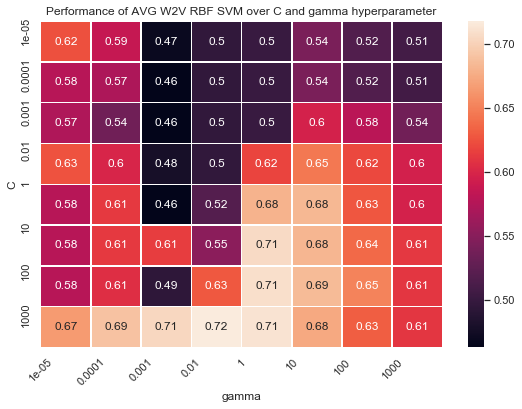

In [190]:
import seaborn as sns
scores = results_tr_tfidf['mean_test_AUC'].reshape(len(C_range),len(gamma_range))
sns.set()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(scores, annot=True, linewidths=.5, ax=ax)
plt.xlabel('gamma')
plt.ylabel('C')
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Performance of AVG W2V RBF SVM over C and gamma hyperparameter')
plt.show()



Area under the ROC curve : %f 0.7412013416477704
[[ 17 109]
 [ 24 648]]


Text(0.5, 12.5, 'Predicted label')

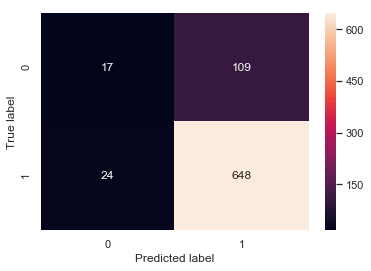

In [191]:
# After finding the best hyperparameter value for AVG W2V which is 0.001, applying RBF SVM on train dataset and predicting
# accuracy/AUC score for cv dataset
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
clf = svm.SVC(kernel='rbf',gamma=0.01,C=1000)
scoring = {'AUC': 'roc_auc'}
clf.fit(tfidf_sent_vectors,y_tr)
#cf = clf.predict(tfidf_sent_vectors_cv)
#Caliberate the classifier.
clf_calibrated=CalibratedClassifierCV(clf, cv='prefit', method='isotonic')
y_pred = clf_calibrated.fit(tfidf_sent_vectors, y_tr).predict(tfidf_sent_vectors_cv) 
pred_cv = clf_calibrated.predict_proba(tfidf_sent_vectors_cv)[:,1]
fpr, tpr, thresholds = roc_curve(y_cv,pred_cv)
roc_auc_cv_tfidf = auc(fpr, tpr)
print('Area under the ROC curve : %f', + roc_auc_cv_tfidf)

#Plotting confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(y_cv, y_pred)
print(conf_mat)
#conf_normalized = conf_mat.astype('int') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat, annot=True, fmt ='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')

Area under the ROC curve : %f 0.7212757140511507
[[ 22 129]
 [ 26 821]]


Text(0.5, 12.5, 'Predicted label')

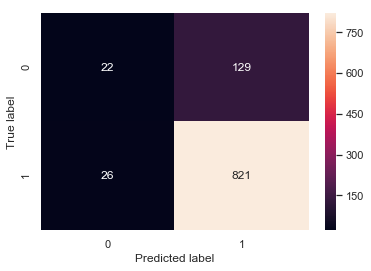

In [192]:
# After finding the best hyperparameter value for AVG W2V which is 0.001, applying RBF SVM on train dataset and predicting
# accuracy/AUC score for cv dataset
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
clf = svm.SVC(kernel='rbf',gamma=0.01,C=1000)
scoring = {'AUC': 'roc_auc'}
clf.fit(tfidf_sent_vectors,y_tr)
#cf = clf.predict(tfidf_sent_vectors_test)
#Caliberate the classifier.
clf_calibrated=CalibratedClassifierCV(clf, cv='prefit', method='isotonic')
y_pred = clf_calibrated.fit(tfidf_sent_vectors, y_tr).predict(tfidf_sent_vectors_test) 
pred_test = clf_calibrated.predict_proba(tfidf_sent_vectors_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test,pred_test)
roc_auc_test_tfidf = auc(fpr, tpr)
print('Area under the ROC curve : %f', + roc_auc_test_tfidf)

#Plotting confusion matrix
import seaborn as sns
#y_pred = np.argmax(cf, axis=1)
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
#conf_normalized = conf_mat.astype('int') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat, annot=True, fmt ='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')


# [6] Conclusions

In [193]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable
table = PrettyTable(["model","C value","Gamma Value","ROC"])
table.add_row(["RBF SVM using BoW", "10","0.01","0.9"])
table.add_row(["RBF SVM using TFIDF", "10","0.01","0.84"])
table.add_row(["RBF SVM using AVG W2V", "1000","0.01","0.5"])
table.add_row(["RBF SVM using TFIDF W2V", "1000","0.01","0.72"])
print(table)

+-------------------------+---------+-------------+------+
|          model          | C value | Gamma Value | ROC  |
+-------------------------+---------+-------------+------+
|    RBF SVM using BoW    |    10   |     0.01    | 0.9  |
|   RBF SVM using TFIDF   |    10   |     0.01    | 0.84 |
|  RBF SVM using AVG W2V  |   1000  |     0.01    | 0.5  |
| RBF SVM using TFIDF W2V |   1000  |     0.01    | 0.72 |
+-------------------------+---------+-------------+------+


Observation:
    
    Except AVG Weighted W2V model, all the three models are performing well.